In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize
from scipy.constants import k, e

import setup
from yalrf import YalRF, Netlist
from yalrf.Analyses import AC, MultiToneHarmonicBalance

## Negative Resistance

[INFO]: YalRF.Analyses.DC: Starting DC analysis.
[INFO]: YalRF.Analyses.DC: Starting nonlinear DC solver ...
[INFO]: YalRF.Analyses.DC: The solver took 18 iterations.
[INFO]: YalRF.Analyses.DC: Finished DC analysis.
DC Voltages:
nx1:	0.0010 V
nvcc:	5.0000 V
ny1:	0.0000 V
nb:	1.0000 V
ne:	0.2859 V
nin:	0.0000 V
nc:	5.0000 V



Text(0, 0.5, '$X_{in}$')

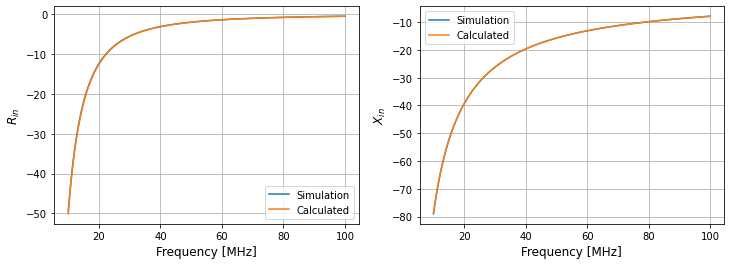

In [30]:
y = YalRF('Oscillator')

# circuit parameters
vcc = 5
vbias = 1
ibias = 1e-3
rl = 850
fosc = 50e6
l = 50e-9
ct = 1 / (l * (2 * np.pi * fosc) ** 2)

n = 0.3 # capactive divider ratio (feedback)
c1 = ct / (1 - n)
c2 = ct / n

# VCC
y.add_idc('I1', 'nx1', 'gnd', dc=vcc)
y.add_gyrator('G1', 'nx1', 'nvcc', 'gnd', 'gnd', 1)

# Vbias
y.add_idc('I2', 'ny1', 'gnd', dc=vbias)
y.add_gyrator('G2', 'ny1', 'nb', 'gnd', 'gnd', 1)

# Ibias
y.add_idc('I3', 'gnd', 'ne', dc=ibias)

# AC supply
iin = y.add_iac('I4', 'nin', 'gnd', 1)

# DC feed and DC block
y.add_inductor('Lfeed', 'nvcc', 'nc', 1e-3)
y.add_capacitor('Cblk', 'nc', 'nin', 1e-6)

# passives
C1 = y.add_capacitor('C1', 'nc', 'ne', c1)
C2 = y.add_capacitor('C2', 'ne', 'gnd', c2)

# bjts
q1 = y.add_bjt('Q1', 'nb', 'nc', 'ne')

q1.options['Is'] = 1e-15
q1.options['Bf'] = 100

# run DC sim
dc1 = y.add_dc_analysis('DC1')
xdc = y.run('DC1')

y.print_dc_voltages('DC1')

# run AC sim
ac1 = y.add_ac_analysis('AC1', start=10e6, stop=100e6, numpts=100, sweeptype='logarithm')
xac = y.run('AC1', xdc)

freqs = y.get_freqs('AC1')
vin = y.get_voltage('AC1', 'nin')
iin = iin.ac

Rin = np.real(vin / iin)
Xin = np.imag(vin / iin)

Rin_calc = - (ibias / (k * 300 / e)) / ((2 * np.pi * freqs)**2 * c1 * c2)
Xin_calc = np.imag(1 / (1j * (2 * np.pi * freqs) * c1) + 1 / (1j * (2 * np.pi * freqs) * c2))

freqs /= 1e6
plt.figure(figsize=(12,4))
plt.subplot(121)
plt.plot(freqs, Rin, label='Simulation')
plt.plot(freqs, Rin_calc, label='Calculated')
plt.grid()
plt.legend()
plt.xlabel('Frequency [MHz]')
plt.ylabel('$R_{in}$')
plt.subplot(122)
plt.plot(freqs, Xin, label='Simulation')
plt.plot(freqs, Xin_calc, label='Calculated')
plt.grid()
plt.legend()
plt.xlabel('Frequency [MHz]')
plt.ylabel('$X_{in}$')

## Large-Signal Transconductance

[INFO]: YalRF.Analyses.DC: Starting DC analysis.
[INFO]: YalRF.Analyses.DC: Starting nonlinear DC solver ...
[INFO]: YalRF.Analyses.DC: The solver took 18 iterations.
[INFO]: YalRF.Analyses.DC: Finished DC analysis.
Alpha level: 0.1
HB total error: 4.46e-16
NR number of iterations: 3
HB iteration converged: True

Alpha level: 0.13999999999999999
HB total error: 9.27e-17
NR number of iterations: 3
HB iteration converged: True

Alpha level: 0.19599999999999998
HB total error: 1.60e-16
NR number of iterations: 3
HB iteration converged: True

Alpha level: 0.2744
HB total error: 3.05e-16
NR number of iterations: 3
HB iteration converged: True

Alpha level: 0.38415999999999995
HB total error: 7.11e-16
NR number of iterations: 3
HB iteration converged: True

Alpha level: 0.5378239999999999
HB total error: 1.74e-15
NR number of iterations: 3
HB iteration converged: True

Alpha level: 0.7529535999999998
HB total error: 4.47e-15
NR number of iterations: 3
HB iteration converged: True

Alpha leve

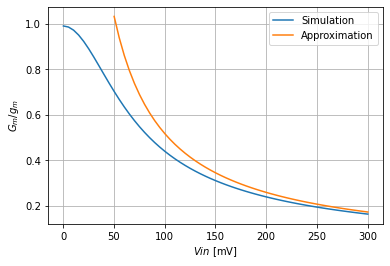

In [28]:
vin = 10e-3
fin = 50e6
vcc = 5
vbias = 1
ibias = 1e-3

net = Netlist('Large Gm')

# VCC
net.add_idc('I1', 'nx', 'gnd', dc=vcc)
net.add_gyrator('G1', 'nx', 'nc', 'gnd', 'gnd', 1)

# input voltage (DC+AC signals)
net.add_idc('I2', 'ny', 'gnd', dc=vbias)
iin = net.add_iac('I3', 'ny', 'gnd', ac=vin, freq=fin)
net.add_gyrator('G2', 'ny', 'nb', 'gnd', 'gnd', 1)

# bias current
net.add_idc('I4', 'gnd', 'ne', dc=ibias)

# decoupling capacitor
net.add_capacitor('C1', 'ne', 'gnd', 1e-6)

# BJT
q1 = net.add_bjt('Q1', 'nb', 'nc', 'ne')
q1.options['Is'] = 1e-15
q1.options['Bf'] = 100

hb = MultiToneHarmonicBalance('HB1', fin, 20)
hb.options['maxiter'] = 100

vi = np.arange(100e-6, 301e-3, 5e-3)
ic = np.zeros(vi.shape)
V0 = None
i = 0
for vin in vi:

    # update input voltage
    iin.ac = vin

    # run harmonic balance
    converged, freqs, Vf, _, _ = hb.run(net, V0)
    V0 = hb.V

    # get time-domain current waveform from BJT and convert to frequency
    ic_td = np.array(q1.Ic, dtype=complex)
    ic_fd = hb.DFT @ ic_td
    ic[i] = np.abs(ic_fd[1] + 1j * ic_fd[2])
    i += 1

# small-signal BJT transconductance
gm = ibias / (k * 300 / e)

plt.figure()
plt.plot(vi * 1e3, ic / vi / gm, label='Simulation')
plt.plot(vi[vi>=50e-3] * 1e3, 2 * ibias / vi[vi>=50e-3] / gm, label='Approximation')
plt.grid()
plt.legend()
plt.xlabel('$Vin$ [mV]')
plt.ylabel('$G_m / g_m$')
plt.show()


[INFO]: YalRF.Analyses.DC: Starting DC analysis.
[INFO]: YalRF.Analyses.DC: Starting nonlinear DC solver ...
[INFO]: YalRF.Analyses.DC: The solver took 18 iterations.
[INFO]: YalRF.Analyses.DC: Finished DC analysis.
Alpha level: 0.1
HB total error: 2.25e-08
NR number of iterations: 5
HB iteration converged: True

Alpha level: 0.13999999999999999
HB total error: 5.49e-06
NR number of iterations: 3
HB iteration converged: True

Alpha level: 0.19599999999999998
HB total error: 9.08e-06
NR number of iterations: 3
HB iteration converged: True

Alpha level: 0.2744
HB total error: 7.51e-08
NR number of iterations: 4
HB iteration converged: True

Alpha level: 0.38415999999999995
HB total error: 9.75e-06
NR number of iterations: 3
HB iteration converged: True

Alpha level: 0.5378239999999999
HB total error: 9.55e-06
NR number of iterations: 3
HB iteration converged: True

Alpha level: 0.7529535999999998
HB total error: 1.01e-05
NR number of iterations: 3
HB iteration converged: True

Alpha leve

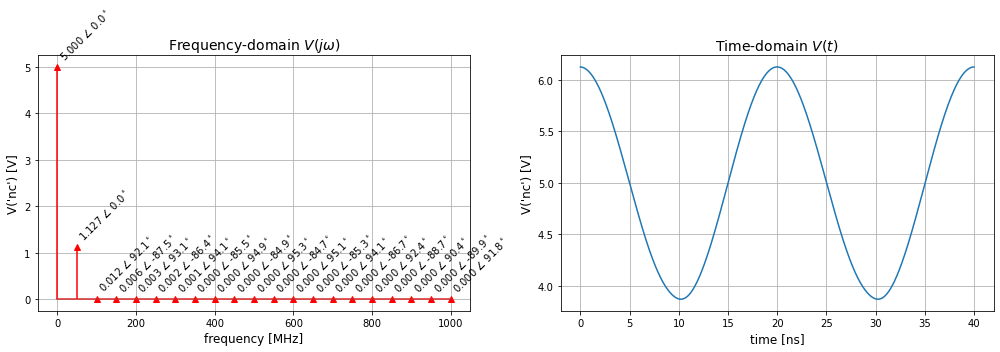

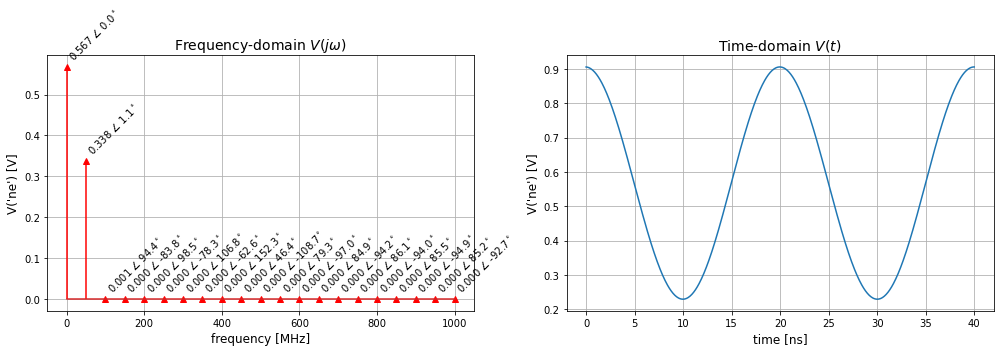

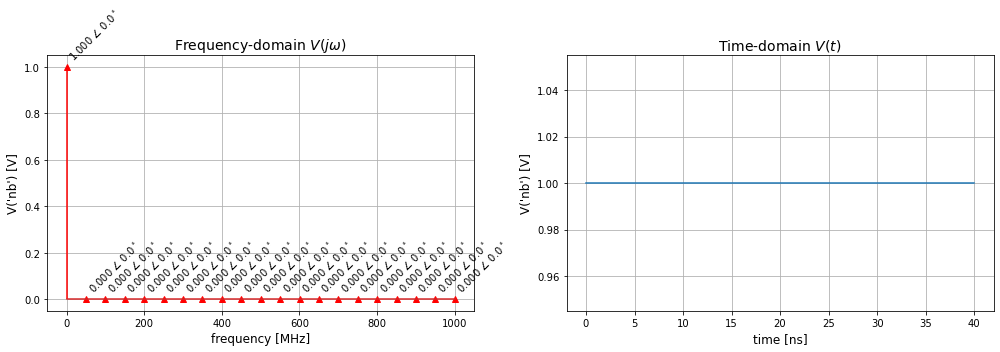

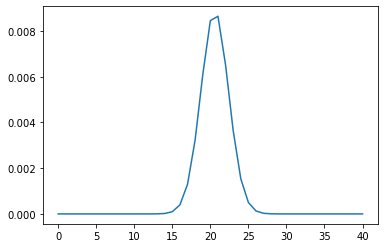

In [3]:
y = Netlist('HB Oscillator Analysis')

# circuit parameters
vcc = 5
vbias = 1
ibias = 1e-3
rl = 850
fosc = 50e6
l = 50e-9
ct = 1 / (l * (2 * np.pi * fosc) ** 2)

n = 0.3 # capactive divider ratio (feedback)
c1 = ct / (1 - n)
c2 = ct / n

# rs = l ** 2 * (2 * np.pi * fosc) ** 2 / rl

numharmonics = 20

f0 = 1 / (2 * np.pi * np.sqrt(l * ct))
V0 = 2 * ibias * rl * (1 - n)

# declare harmonic balance solver
hb = MultiToneHarmonicBalance('HB1')
hb.options['maxiter'] = 100

# VCC
y.add_idc('I1', 'nx1', 'gnd', dc=vcc)
y.add_gyrator('G1', 'nx1', 'nvcc', 'gnd', 'gnd', 1)

# Vbias
y.add_idc('I2', 'ny1', 'gnd', dc=vbias)
y.add_gyrator('G2', 'ny1', 'nb', 'gnd', 'gnd', 1)

# Ibias
y.add_idc('I3', 'gnd', 'ne', dc=ibias)

# passives
# y.add_resistor('Rs', 'nvcc', 'nvccx', rs)
y.add_resistor('Rl', 'nvcc', 'nc', rl)
y.add_inductor('L1', 'nvcc', 'nc', l)
C1 = y.add_capacitor('C1', 'nc', 'ne', c1)
C2 = y.add_capacitor('C2', 'ne', 'gnd', c2)

# bjts
q1 = y.add_bjt('Q1', 'nb', 'nc', 'ne')

q1.options['Is'] = 1e-15
q1.options['Bf'] = 100

# single iteration
converged, freqs, Vf, _, _ = hb.run_oscillator(y, f0, numharmonics, V0, 'nc')

hb.plot_v('nc')
hb.plot_v('ne')
hb.plot_v('nb')
plt.figure()
plt.plot(q1.Ic)
plt.show()

## Oscillator Parameter Sweep

[INFO]: YalRF.Analyses.DC: Starting DC analysis.
[INFO]: YalRF.Analyses.DC: Starting nonlinear DC solver ...
[INFO]: YalRF.Analyses.DC: The solver took 18 iterations.
[INFO]: YalRF.Analyses.DC: Finished DC analysis.
Alpha level: 0.1
HB total error: 2.25e-08
NR number of iterations: 5
HB iteration converged: True

Alpha level: 0.13999999999999999
HB total error: 5.49e-06
NR number of iterations: 3
HB iteration converged: True

Alpha level: 0.19599999999999998
HB total error: 9.08e-06
NR number of iterations: 3
HB iteration converged: True

Alpha level: 0.2744
HB total error: 7.51e-08
NR number of iterations: 4
HB iteration converged: True

Alpha level: 0.38415999999999995
HB total error: 9.74e-06
NR number of iterations: 3
HB iteration converged: True

Alpha level: 0.5378239999999999
HB total error: 9.66e-06
NR number of iterations: 3
HB iteration converged: True

Alpha level: 0.7529535999999998
HB total error: 1.03e-05
NR number of iterations: 3
HB iteration converged: True

Alpha leve

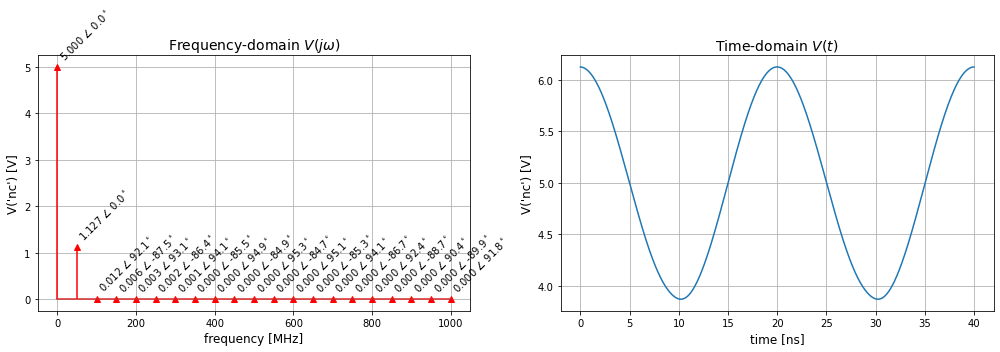

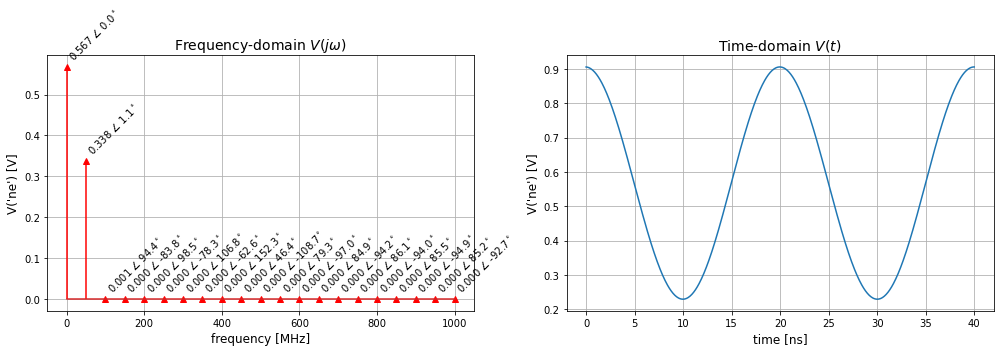

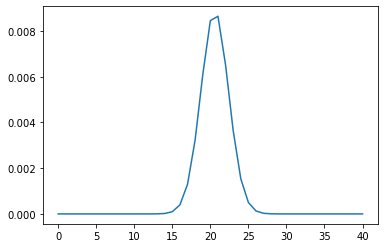

05837.19404049	0.76236119	1.46e-07

HB total error: 1.17e-08
NR number of iterations: 3

Iter	Freq [Hz]	Vosc [V]	mag(Yosc)
102	50005836.71216334	0.76235971	2.03e-10

HB total error: 1.22e-08
NR number of iterations: 3

Iter	Freq [Hz]	Vosc [V]	mag(Yosc)
103	50005836.52789350	0.76236588	4.20e-10

HB total error: 1.17e-08
NR number of iterations: 3

Iter	Freq [Hz]	Vosc [V]	mag(Yosc)
104	50005836.85566635	0.76235930	1.46e-10

HB total error: 1.20e-08
NR number of iterations: 3

Iter	Freq [Hz]	Vosc [V]	mag(Yosc)
105	50005836.92415716	0.76236288	4.67e-10

HB total error: 1.18e-08
NR number of iterations: 3

Iter	Freq [Hz]	Vosc [V]	mag(Yosc)
106	50005836.76516180	0.76236050	3.53e-11

HB total error: 1.31e-07
NR number of iterations: 3

Iter	Freq [Hz]	Vosc [V]	mag(Yosc)
107	50005836.69014959	0.76236448	1.46e-07

HB total error: 1.18e-08
NR number of iterations: 3

Iter	Freq [Hz]	Vosc [V]	mag(Yosc)
108	50005836.81428716	0.76236060	9.38e-11

HB total error: 1.15e-08
NR number of iterations: 3

I

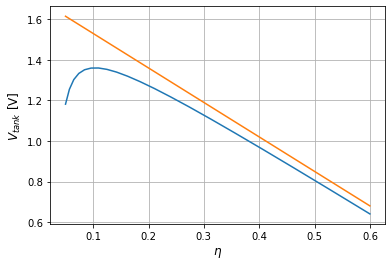

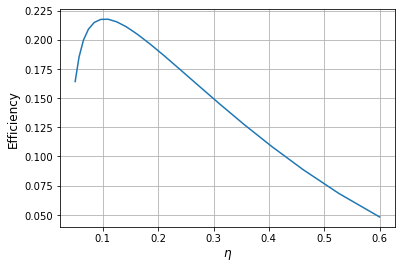

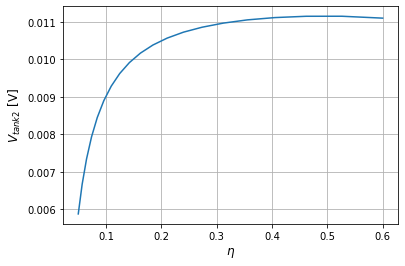

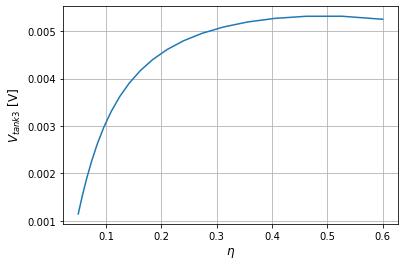

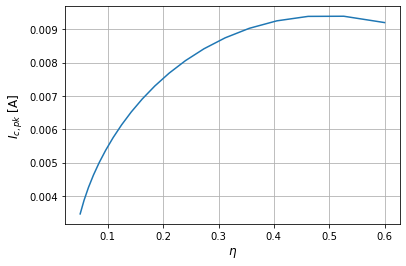

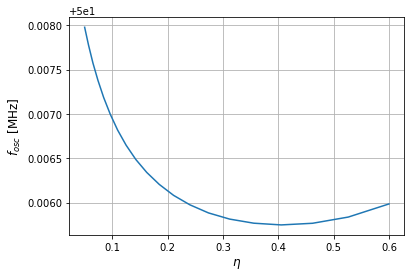

In [31]:
y = Netlist('Oscillator Parameter Sweep')

# circuit parameters
vcc = 5
vbias = 1
ibias = 1e-3
rl = 850
fosc = 50e6
l = 50e-9
ct = 1 / (l * (2 * np.pi * fosc) ** 2)

n = 0.3 # capactive divider ratio (feedback)
c1 = ct / (1 - n)
c2 = ct / n

# rs = l ** 2 * (2 * np.pi * fosc) ** 2 / rl

numharmonics = 20

f0 = 1 / (2 * np.pi * np.sqrt(l * ct))
V0 = 2 * ibias * rl * (1 - n)

# declare harmonic balance solver
hb = MultiToneHarmonicBalance('HB1')
hb.options['maxiter'] = 100

# VCC
y.add_idc('I1', 'nx1', 'gnd', dc=vcc)
y.add_gyrator('G1', 'nx1', 'nvcc', 'gnd', 'gnd', 1)

# Vbias
y.add_idc('I2', 'ny1', 'gnd', dc=vbias)
y.add_gyrator('G2', 'ny1', 'nb', 'gnd', 'gnd', 1)

# Ibias
y.add_idc('I3', 'gnd', 'ne', dc=ibias)

# passives
# y.add_resistor('Rs', 'nvcc', 'nvccx', rs)
y.add_resistor('Rl', 'nvcc', 'nc', rl)
y.add_inductor('L1', 'nvcc', 'nc', l)
C1 = y.add_capacitor('C1', 'nc', 'ne', c1)
C2 = y.add_capacitor('C2', 'ne', 'gnd', c2)

# bjts
q1 = y.add_bjt('Q1', 'nb', 'nc', 'ne')

q1.options['Is'] = 1e-15
q1.options['Bf'] = 100

# single iteration
converged, freqs, Vf, _, _ = hb.run_oscillator(y, f0, numharmonics, V0, 'nc')

hb.plot_v('nc')
hb.plot_v('ne')
plt.figure()
plt.plot(q1.Ic)
plt.show()

# start timing the sweep
begin = time.time()

# loop varying 'n'
freqs = []
vtank = []
vtank2 = []
vtank3 = []
ipk = []
pwr = []
vtank_calc = []
eff = []
nvec = np.geomspace(0.05, 0.6, 20)
iter_cnt = 0
for n in nvec:
    # update netlist
    C1.C = ct / (1 - n)
    C2.C = ct / n
  
    # run oscillator analysis
    if iter_cnt == 0:
        hb.run_oscillator(y, f0, numharmonics, V0, 'nc')
    else:
        hb.run_oscillator(y, f0, numharmonics, V0, 'nc', useprev=True)
    
    # sample the results
    freqs.append(hb.freq / 1e6)
    ipk.append(np.max(q1.Ic))
    vtank2.append(np.abs(hb.get_v('nc')[2]) / np.abs(hb.get_v('nc')[1]))
    vtank3.append(np.abs(hb.get_v('nc')[3]) / np.abs(hb.get_v('nc')[1]))
    vtank.append(np.abs(hb.get_v('nc')[1]))
    vtank_calc.append(2 * ibias * rl * (1 - n))
    eff.append(np.abs(hb.get_v('nc')[1])**2 / (2 * rl) / (vcc * ibias))

    iter_cnt += 1

# stop timing the sweep
end = time.time()
print('Shape of V: {}'.format(hb.V.shape))
print('Running time: {}'.format(end-begin))

plt.figure()
plt.plot(nvec, np.array(eff) * 100)
plt.xlabel('$n$')
plt.ylabel('Efficiency [%]')
plt.grid()

plt.figure()
plt.plot(nvec, vtank, label='Simulated')
plt.plot(nvec, vtank_calc, label='Calculated')
plt.xlabel('$n$')
plt.ylabel('$V_{out}$ [V]')
plt.grid()
plt.legend()

plt.figure()
plt.plot(nvec, vtank2)
plt.xlabel('$\eta$')
plt.ylabel('$V_{tank2}$ [V]')
plt.grid()

plt.figure()
plt.plot(nvec, vtank3)
plt.xlabel('$\eta$')
plt.ylabel('$V_{tank3}$ [V]')
plt.grid()

plt.figure()
plt.plot(nvec, ipk)
plt.xlabel('$\eta$')
plt.ylabel('$I_{c,pk}$ [A]')
plt.grid()

plt.figure()
plt.plot(nvec, freqs)
plt.xlabel('$\eta$')
plt.ylabel('$f_{osc}$ [MHz]')
plt.grid()
plt.show()


## Oscillator Optimization

sc [V]	mag(Yosc)
82	50006888.49311478	1.36066575	6.26e-10

HB total error: 3.25e-07
NR number of iterations: 3

Iter	Freq [Hz]	Vosc [V]	mag(Yosc)
83	50006888.77807772	1.36062605	9.10e-10

HB total error: 8.69e-08
NR number of iterations: 3

Iter	Freq [Hz]	Vosc [V]	mag(Yosc)
84	50006887.62631071	1.36063095	3.72e-09

HB total error: 9.03e-08
NR number of iterations: 3

Iter	Freq [Hz]	Vosc [V]	mag(Yosc)
85	50006889.14023903	1.36065337	7.07e-10

HB total error: 3.35e-07
NR number of iterations: 3

Iter	Freq [Hz]	Vosc [V]	mag(Yosc)
86	50006888.85527609	1.36069308	9.90e-10

HB total error: 3.27e-07
NR number of iterations: 3

Iter	Freq [Hz]	Vosc [V]	mag(Yosc)
87	50006888.79737732	1.36064280	4.35e-10

HB total error: 9.05e-08
NR number of iterations: 3

Iter	Freq [Hz]	Vosc [V]	mag(Yosc)
88	50006888.15025307	1.36065518	1.77e-09

HB total error: 9.03e-08
NR number of iterations: 3

Iter	Freq [Hz]	Vosc [V]	mag(Yosc)
89	50006888.89274254	1.36065383	8.82e-11

HB total error: 3.25e-07
NR number of 

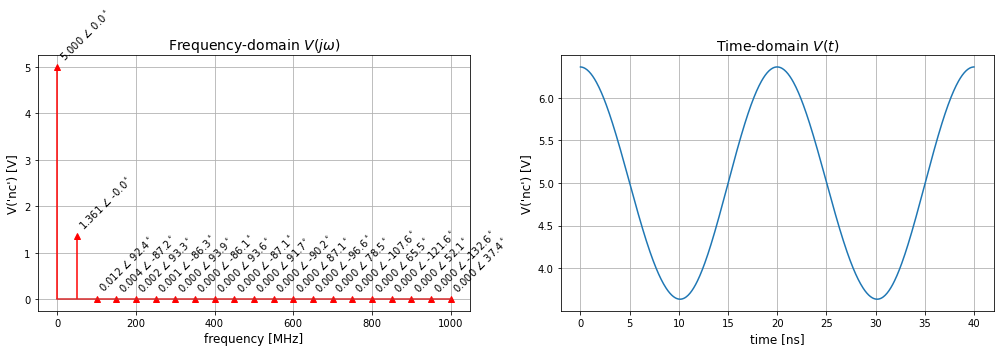

In [40]:
y = Netlist('Oscillator Optimization')

# circuit parameters
vcc = 5
vbias = 1
ibias = 1e-3
rl = 850
fosc = 50e6
l = 50e-9
ct = 1 / (l * (2 * np.pi * fosc) ** 2)

n = 0.2 # capactive divider ratio (feedback)
c1 = ct / (1 - n)
c2 = ct / n

# rs = l ** 2 * (2 * np.pi * fosc) ** 2 / rl

numharmonics = 20

f0 = 1 / (2 * np.pi * np.sqrt(l * ct))
V0 = 2 * ibias * rl * (1 - n)

# declare harmonic balance solver
hb = MultiToneHarmonicBalance('HB1')
hb.options['maxiter'] = 100

# VCC
y.add_idc('I1', 'nx1', 'gnd', dc=vcc)
y.add_gyrator('G1', 'nx1', 'nvcc', 'gnd', 'gnd', 1)

# Vbias
y.add_idc('I2', 'ny1', 'gnd', dc=vbias)
y.add_gyrator('G2', 'ny1', 'nb', 'gnd', 'gnd', 1)

# Ibias
y.add_idc('I3', 'gnd', 'ne', dc=ibias)

# passives
# y.add_resistor('Rs', 'nvcc', 'nvccx', rs)
y.add_resistor('Rl', 'nvcc', 'nc', rl)
y.add_inductor('L1', 'nvcc', 'nc', l)
C1 = y.add_capacitor('C1', 'nc', 'ne', c1)
C2 = y.add_capacitor('C2', 'ne', 'gnd', c2)

# bjts
q1 = y.add_bjt('Q1', 'nb', 'nc', 'ne')

q1.options['Is'] = 1e-15
q1.options['Bf'] = 100

def objFunc(x, info):
    global hb
    # update netlist
    C1.C = ct / (1 - x)
    C2.C = ct / x
    # initial condition for oscillator
    f0 = 1 / (2 * np.pi * np.sqrt(l * ct))
    V0 = 2 * ibias * rl * (1 - x)
    # run oscillator analysis
    hb.run_oscillator(y, f0, numharmonics, V0, 'nc')
    info['itercnt'] += 1
    return - (np.abs(hb.get_v('nc')[1])**2 / (2 * rl) / (vcc * ibias))


begin = time.time()
bounds = (0.05, 0.5)
args = ({'itercnt' : 0},)
xopt = optimize.minimize_scalar(fun      = objFunc,
                                bounds   = bounds,
                                method   = 'bounded',
                                args     = args,
                                tol      = 1e-3)
end = time.time()

print('Shape of V: {}'.format(hb.V.shape))
print('Running time: {}'.format(end-begin))

print(xopt)
print(xopt.x)
hb.print_v('nc')
hb.plot_v('nc')
plt.show()

